# Vanila PyTorch

In [1]:
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

from torchvision.datasets.mnist import MNIST
from torch.utils.data import DataLoader, Dataset, random_split

In [2]:
import random

seed = 1004
random.seed(seed)
th.manual_seed(seed)
if th.cuda.is_available():
    th.cuda.manual_seed(seed)

In [3]:
# load dataset

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))])

train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)

In [4]:
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

In [5]:
test_dataset

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

In [6]:
train_dataset, val_dataset = random_split(train_dataset, [54000, 6000])

In [7]:
print(f'Train size: {len(train_dataset)}')
print(f'Validation size: {len(val_dataset)}')
print(f'Test size: {len(test_dataset)}')

Train size: 54000
Validation size: 6000
Test size: 10000


In [8]:
batch_size = 64

trian_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

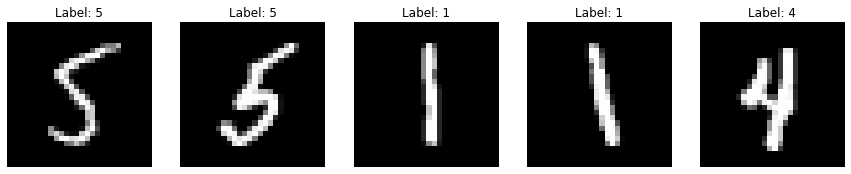

In [9]:
num_sample = 5
random_idx = np.random.randint(0, len(train_dataset), num_sample)

plt.figure(figsize=(15, 3))
for i, idx in enumerate(random_idx):
    img, label = train_dataset[idx]
    plt.subplot(1, num_sample, i+1)
    plt.title(f'Label: {label}')
    plt.imshow(img.squeeze(), cmap='gray')
    plt.axis('off')

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 10)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        out = F.log_softmax(x, dim=1)
        return out

In [11]:
def train(model, train_loader, optimizer, epoch, device):
    model.train()
    train_losses = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        train_losses.append(loss.item())
        
        loss.backward()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
            
    return np.mean(train_losses)

def test(model, test_loader, device):
    model.eval()
    test_loss = 0
    correct = 0

    with th.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print(f'\nTest set: Average loss: {test_loss:.4f}, '
          f'Accuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset)}%)\n')

    return test_loss

In [12]:
import copy

def run(model,
        train_loader,
        val_loader,
        test_loader,
        optimizer,
        num_epoch):
    
    device = th.device('cuda' if th.cuda.is_available() else 'cpu')
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.7)
    model = model.to(device)
    train_losses = []
    val_losses = []
    
    best_model = None
    min_val_loss = np.inf
    
    for epoch in range(1, num_epoch + 1):
        train_loss = train(model, train_loader, optimizer, epoch, device)
        val_loss = test(model, val_loader, device)
        scheduler.step()

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        if val_loss < min_val_loss:
            min_val_loss = val_loss
            best_model = copy.deepcopy(model)

    # th.save(model.state_dict(), 'mnist.pt')
    th.save(best_model.state_dict(), 'mnist.pt')

    # test_loss = test(model, test_loader, device)
    test_loss = test(best_model, test_loader, device)

    return train_losses, val_losses, test_loss


In [13]:
model = Net()
optimizer = optim.Adadelta(model.parameters(), lr=1.0)
history = run(model, trian_loader, val_loader, test_loader, optimizer, 14)

Train Epoch: 1 [0/54000 (0%)]	Loss: 2.304230
Train Epoch: 1 [6400/54000 (12%)]	Loss: 0.152449
Train Epoch: 1 [12800/54000 (24%)]	Loss: 0.302747
Train Epoch: 1 [19200/54000 (36%)]	Loss: 0.376179
Train Epoch: 1 [25600/54000 (47%)]	Loss: 0.168665
Train Epoch: 1 [32000/54000 (59%)]	Loss: 0.190544
Train Epoch: 1 [38400/54000 (71%)]	Loss: 0.150985
Train Epoch: 1 [44800/54000 (83%)]	Loss: 0.124228
Train Epoch: 1 [51200/54000 (95%)]	Loss: 0.081385

Test set: Average loss: 0.1121, Accuracy: 5758/6000 (95.96666666666667%)

Train Epoch: 2 [0/54000 (0%)]	Loss: 0.192086
Train Epoch: 2 [6400/54000 (12%)]	Loss: 0.010522
Train Epoch: 2 [12800/54000 (24%)]	Loss: 0.085059
Train Epoch: 2 [19200/54000 (36%)]	Loss: 0.126042
Train Epoch: 2 [25600/54000 (47%)]	Loss: 0.196535
Train Epoch: 2 [32000/54000 (59%)]	Loss: 0.008515
Train Epoch: 2 [38400/54000 (71%)]	Loss: 0.020873
Train Epoch: 2 [44800/54000 (83%)]	Loss: 0.150342
Train Epoch: 2 [51200/54000 (95%)]	Loss: 0.079477

Test set: Average loss: 0.0725, Accu

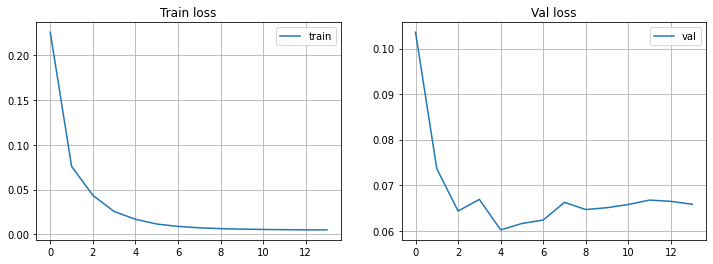

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(history[0], label='train')
ax[1].plot(history[1], label='val')
ax[0].set_title('Train loss')
ax[1].set_title('Val loss')
ax[0].legend()
ax[1].legend()
ax[0].grid(True)
ax[1].grid(True)

In [ ]:
model = Net()
model.load_state_dict(th.load('mnist.pt'))

In [45]:
test(model, test_loader, th.device('cuda'))


Test set: Average loss: 0.0681, Accuracy: 9808/10000 (98.08%)



0.06812374950675294

In [48]:
pred_ys = model(th.stack([test_dataset[i][0] for i in range(len(test_dataset))]).to(th.device('cuda'))).argmax(dim=1).cpu().numpy()

In [49]:
pred_ys.shape

(10000,)

In [54]:
(pred_ys == np.array([test_dataset[i][1] for i in range(len(test_dataset))])).sum() / len(test_dataset)

0.9824

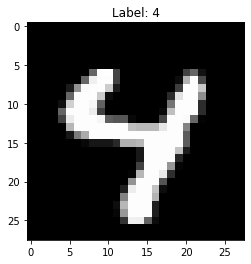

In [57]:
plt.imshow(test_dataset[1010][0].squeeze(), cmap='gray')
plt.title(f'Label: {pred_ys[1010]}')
plt.show()

# Pytorch Lightning

- Lightning은 Pytorch를 더 쉽게 사용할 수 있도록 도와주는 라이브러리입니다.

In [1]:
import torch as th
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchmetrics import Accuracy
from torchvision import transforms
from torchvision.datasets import MNIST


from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks.progress.tqdm_progress import TQDMProgressBar
from pytorch_lightning.loggers import TensorBoardLogger

In [4]:
import os

# find DATASET_PATH from environment variable, if not, use './data'
DATASET_PATH = os.environ.get('DATASET_PATH', './data')
BATCH_SIZE = 256 if th.cuda.is_available() else 64


In [9]:
class LitMNISTModel(LightningModule):
    def __init__(self, 
                 data_dir: str = DATASET_PATH, 
                 hidden_dim: int = 128, 
                 learning_rate: float = 2e-4):
        
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_classes = 10
        self.learning_rate = learning_rate
        
        self.input_dims = (1, 28, 28)
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])
        
        channels, width, height = self.input_dims
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(channels * width * height, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim, self.num_classes),
        )
        
        self.val_acc = Accuracy(task='multiclass',
                                num_classes=self.num_classes)
        self.test_acc = Accuracy(task='multiclass',
                                 num_classes=self.num_classes)

    def forward(self, x):
        x = self.model(x)
        out = F.log_softmax(x, dim=1)
        return out

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = th.argmax(logits, dim=1)
        self.val_acc.update(preds, y)
        
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', self.val_acc, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = th.argmax(logits, dim=1)
        self.test_acc.update(preds, y)
        
        self.log('test_loss', loss, prog_bar=True)
        self.log('test_acc', self.test_acc, prog_bar=True)

    def configure_optimizers(self):
        optimizer = th.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    def prepare_data(self):
        MNIST(DATASET_PATH, train=True, download=True)
        MNIST(DATASET_PATH, train=False, download=True)

    def setup(self, stage=None):
        if stage == 'fit' or stage is None:
            mnist_train = MNIST(DATASET_PATH, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_train, [55000, 5000])
            
        if stage == 'test' or stage is None:
            self.mnist_test = MNIST(DATASET_PATH, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=BATCH_SIZE, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=BATCH_SIZE, shuffle=False)

    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=BATCH_SIZE, shuffle=False)

In [12]:
model = LitMNISTModel(hidden_dim=256, learning_rate=2e-4)

trainer = Trainer(accelerator='auto',
                  devices=1 if th.cuda.is_available() else None,
                  max_epochs=5,
                  callbacks=[TQDMProgressBar(refresh_rate=20)],
                  logger=TensorBoardLogger('lightning_logs', name='mnist'))

trainer.fit(model=model)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name     | Type               | Params
------------------------------------------------
0 | model    | Sequential         | 269 K 
1 | val_acc  | MulticlassAccuracy | 0     
2 | test_acc | MulticlassAccuracy | 0     
------------------------------------------------
269 K     Trainable params
0         Non-trainable params
269 K     Total params
1.077     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


In [13]:
trainer.test()

/home/user/anaconda3/envs/rl/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:134: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
Restoring states from the checkpoint path at lightning_logs/mnist/version_1/checkpoints/epoch=4-step=1075.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
Loaded model weights from checkpoint at lightning_logs/mnist/version_1/checkpoints/epoch=4-step=1075.ckpt
/home/user/anaconda3/envs/rl/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9639000296592712
        test_loss           0.11687740683555603
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.11687740683555603, 'test_acc': 0.9639000296592712}]